In [1]:
import pandas as pd
import numpy as np
import math
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from collections import Counter
import plotly.express as px

In [2]:
def calc_metrics(tp, tn, fp, fn):
    # balanced accuracy
    se_total = tp + fn
    sp_total = fp + tn

    # Sensitivity / recall / TPR
    se = 0
    if se_total > 0:
        se = tp / se_total

    # Specificity / TNR
    sp = 0
    if sp_total > 0:
        sp = tn / sp_total

    # Balanced accuracy (Sensitivity + specificity) / 2
    bacc = (se + sp) / 2

    # Precision / PPV
    p_total = tp + fp
    p = 0
    if p_total > 0:
        p = tp / p_total

    # F1 score
    f1 = 0
    if (p + se) > 0:
        f1 = 2 * ((p * se)/(p+se))

    # MCC
    mcc = np.nan
    d = math.sqrt((tp + fp)*(tp + fn)*(tn + fp)*(tn + fn))
    if d > 0:
        mcc = ((tp * tn) - (fp * fn)) / d

    return [round(bacc, 2), round(p, 2), round(se, 2), round(sp, 2), round(f1,2), round(mcc, 2)]

In [3]:
# dataset
df_pos = pd.read_csv('data/binary_pdbs_classes.csv')
df_neg = pd.read_csv('data/binary_pdb_negatives.csv')
df = pd.concat([df_pos, df_neg])
# df = df_pos # uncomment and comment previous line when only positives wanted
df = df.loc[df['pdb_residue_id'].notnull()] # filter missing residues
df

/tmp/ipykernel_1378365/2546653529.py:2: DtypeWarning: Columns (3,13,15) have mixed types. Specify dtype option on import or set low_memory=False.
  df_pos = pd.read_csv('data/binary_pdbs_classes.csv')
/tmp/ipykernel_1378365/2546653529.py:3: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df_neg = pd.read_csv('data/binary_pdb_negatives.csv')


,pdb_id,pdb_chain,seqres_index,pdb_residue_id,REGION,CURATED,RDB1,RDB2,CATEGORY,UNIT_CURATED,UNIT_RDB1,UNIT_RDB2,PDB,classes,classes_names,topologies,topologies_names
2,3u3w,B,3,3.0,0,0,1,0,1,0,3u3wB_3_21,0,3u3wB,3,Elongated repeats,3.3,Alpha-solenoid
3,3u3w,B,4,4.0,0,0,1,0,1,0,3u3wB_3_21,0,3u3wB,3,Elongated repeats,3.3,Alpha-solenoid
4,3u3w,B,5,5.0,0,0,1,0,1,0,3u3wB_3_21,0,3u3wB,3,Elongated repeats,3.3,Alpha-solenoid
5,3u3w,B,6,6.0,0,0,1,0,1,0,3u3wB_3_21,0,3u3wB,3,Elongated repeats,3.3,Alpha-solenoid
6,3u3w,B,7,7.0,0,0,1,0,1,0,3u3wB_3_21,0,3u3wB,3,Elongated repeats,3.3,Alpha-solenoid
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
733045,6b9i,A,284,284.0,NaN,0,0,0,0,0,0,0,6b9iA,NaN,NaN,NaN,NaN
733046,6b9i,A,285,285.0,NaN,0,0,0,0,0,0,0,6b9iA,NaN,NaN,NaN,NaN
733047,6b9i,A,286,286.0,NaN,0,0,0,0,0,0,0,6b9iA,NaN,NaN,NaN,NaN
733048,6b9i,A,287,287.0,NaN,0,0,0,0,0,0,0,6b9iA,NaN,NaN,NaN,NaN


In [4]:
# REPEATSDB-LITE EVALUATION (generate tables)

# rdb1
df['TP_1'] = np.where((df['RDB1'] == df['CURATED']) & (df['CURATED'] == 1), 1, 0)
df['TN_1'] = np.where((df['RDB1'] == df['CURATED']) & (df['CURATED'] == 0), 1, 0)
df['FP_1'] = np.where((df['RDB1'] != df['CURATED']) & (df['CURATED'] == 0), 1, 0)
df['FN_1'] = np.where((df['RDB1'] != df['CURATED']) & (df['CURATED'] == 1), 1, 0)

df['TP_2'] = np.where((df['RDB2'] == df['CURATED']) & (df['CURATED'] == 1), 1, 0)
df['TN_2'] = np.where((df['RDB2'] == df['CURATED']) & (df['CURATED'] == 0), 1, 0)
df['FP_2'] = np.where((df['RDB2'] != df['CURATED']) & (df['CURATED'] == 0), 1, 0)
df['FN_2'] = np.where((df['RDB2'] != df['CURATED']) & (df['CURATED'] == 1), 1, 0)

df

,pdb_id,pdb_chain,seqres_index,pdb_residue_id,REGION,CURATED,RDB1,RDB2,CATEGORY,UNIT_CURATED,...,topologies,topologies_names,TP_1,TN_1,FP_1,FN_1,TP_2,TN_2,FP_2,FN_2
2,3u3w,B,3,3.0,0,0,1,0,1,0,...,3.3,Alpha-solenoid,0,0,1,0,0,1,0,0
3,3u3w,B,4,4.0,0,0,1,0,1,0,...,3.3,Alpha-solenoid,0,0,1,0,0,1,0,0
4,3u3w,B,5,5.0,0,0,1,0,1,0,...,3.3,Alpha-solenoid,0,0,1,0,0,1,0,0
5,3u3w,B,6,6.0,0,0,1,0,1,0,...,3.3,Alpha-solenoid,0,0,1,0,0,1,0,0
6,3u3w,B,7,7.0,0,0,1,0,1,0,...,3.3,Alpha-solenoid,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
733045,6b9i,A,284,284.0,NaN,0,0,0,0,0,...,NaN,NaN,0,1,0,0,0,1,0,0
733046,6b9i,A,285,285.0,NaN,0,0,0,0,0,...,NaN,NaN,0,1,0,0,0,1,0,0
733047,6b9i,A,286,286.0,NaN,0,0,0,0,0,...,NaN,NaN,0,1,0,0,0,1,0,0
733048,6b9i,A,287,287.0,NaN,0,0,0,0,0,...,NaN,NaN,0,1,0,0,0,1,0,0


In [5]:
df_prot = df.groupby(['pdb_id', 'pdb_chain']).agg({'CATEGORY': 'first', 'seqres_index':'count','TP_1': 'sum', 'TN_1': 'sum', 'FP_1': 'sum', 'FN_1': 'sum', 'TP_2': 'sum', 'TN_2': 'sum', 'FP_2': 'sum', 'FN_2': 'sum'})
df_prot.reset_index(inplace=True)
df_prot

,pdb_id,pdb_chain,CATEGORY,seqres_index,TP_1,TN_1,FP_1,FN_1,TP_2,TN_2,FP_2,FN_2
0,102l,A,0,163,0,71,92,0,0,49,114,0
1,13pk,A,0,415,0,346,69,0,0,217,198,0
2,1a0t,P,1,413,0,2,0,411,353,2,0,58
3,1a0t,Q,1,413,256,0,2,155,192,2,0,219
4,1a12,A,1,401,357,18,0,26,357,6,12,26
...,...,...,...,...,...,...,...,...,...,...,...,...
5252,7w3h,a,1,373,0,161,0,212,155,70,91,57
5253,7w3i,a,1,373,0,161,0,212,152,58,103,60
5254,7w3j,a,1,373,0,161,0,212,194,156,5,18
5255,7w3k,a,1,373,0,161,0,212,204,104,57,8


In [6]:
# protein level matrix
# rdb1
df_prot_lvl = pd.DataFrame()
df_prot_lvl['TP_1'] = np.where(((df_prot['TP_1'] > 0) | (df_prot['FP_1'] > 0)) & (df_prot['CATEGORY'] == 1), 1, 0)
df_prot_lvl['TN_1'] = np.where(((df_prot['TP_1'] == 0) & (df_prot['FP_1'] == 0)) & (df_prot['CATEGORY'] == 0), 1, 0)
df_prot_lvl['FP_1'] = np.where(((df_prot['TP_1'] > 0) | (df_prot['FP_1'] > 0)) & (df_prot['CATEGORY'] == 0), 1, 0)
df_prot_lvl['FN_1'] = np.where(((df_prot['TP_1'] == 0) & (df_prot['FP_1'] == 0)) & (df_prot['CATEGORY'] == 1), 1, 0)

df_prot_lvl['TP_2'] = np.where(((df_prot['TP_2'] > 0) | (df_prot['FP_2'] > 0)) & (df_prot['CATEGORY'] == 1), 1, 0)
df_prot_lvl['TN_2'] = np.where(((df_prot['TP_2'] == 0) | (df_prot['FP_2'] == 0)) & (df_prot['CATEGORY'] == 0), 1, 0)
df_prot_lvl['FP_2'] = np.where(((df_prot['TP_2'] > 0) | (df_prot['FP_2'] > 0)) & (df_prot['CATEGORY'] == 0), 1, 0)
df_prot_lvl['FN_2'] = np.where(((df_prot['TP_2'] == 0) | (df_prot['FP_2'] == 0)) & (df_prot['CATEGORY'] == 1), 1, 0)



In [7]:
df_prot_lvl.columns=pd.MultiIndex.from_arrays([['RDB1', 'RDB1', 'RDB1', 'RDB1', 'RDB2', 'RDB2', 'RDB2', 'RDB2'], ['TP', 'TN', 'FP', 'FN', 'TP', 'TN', 'FP', 'FN']])
print(df_prot_lvl)
# tp, tn fp, fn
# bacc, p, se, sp, f1, mcc
matrix1 = *df_prot_lvl['RDB1'].sum(), calc_metrics(*df_prot_lvl['RDB1'].sum())
matrix2 = *df_prot_lvl['RDB2'].sum(), calc_metrics(*df_prot_lvl['RDB2'].sum())
matrix2[4][0]

     RDB1          RDB2         
       TP TN FP FN   TP TN FP FN
0       0  0  1  0    0  1  1  0
1       0  0  1  0    0  1  1  0
2       0  0  0  1    1  0  0  1
3       1  0  0  0    1  0  0  1
4       1  0  0  0    1  0  0  0
...   ... .. .. ..  ... .. .. ..
5252    0  0  0  1    1  0  0  0
5253    0  0  0  1    1  0  0  0
5254    0  0  0  1    1  0  0  0
5255    0  0  0  1    1  0  0  0
5256    0  0  1  0    0  1  1  0

[5257 rows x 8 columns]


0.61

In [8]:
data = []
data.append(['RDBLITE1', matrix1[0], matrix1[1], matrix1[2], matrix1[3], len(df_prot_lvl), round(matrix1[4][0],2), round(matrix1[4][1],2), round(matrix1[4][2],2), round(matrix1[4][3],2), round(matrix1[4][4],2), round(matrix1[4][5],2)])
data.append(['RDBLITE2',  matrix2[0], matrix2[1], matrix2[2], matrix2[3], len(df_prot_lvl), round(matrix2[4][0],2), round(matrix2[4][1],2), round(matrix2[4][2],2), round(matrix2[4][3],2), round(matrix2[4][4],2), round(matrix2[4][5],2)])
table = pd.DataFrame(data, columns=['TOOL', 'TP', 'FP', 'TN', 'FN', 'TOTAL', 'BALANCED ACCURACY', 'PRECISION', 'RECALL', 'F-SCORE', 'MCC', 'TNR1'])
table.to_csv('tables/table_protein_level.csv', index=False)
print(table)

       TOOL    TP    FP    TN    FN  TOTAL  BALANCED ACCURACY  PRECISION  \
0  RDBLITE1  1841   774  1045  1597   5257               0.48       0.64   
1  RDBLITE2  3377  1819  1691  1428   5257               0.61       0.67   

   RECALL  F-SCORE   MCC  TNR1  
0    0.54     0.43  0.58 -0.04  
1    0.70     0.52  0.68  0.22  


In [9]:
# Region overlap
df_prot.set_index(['pdb_id', 'pdb_chain', 'seqres_index'], inplace=True)
df_prot = df_prot.drop(columns=['CATEGORY'])
df_prot.columns=pd.MultiIndex.from_arrays([['RDB1', 'RDB1', 'RDB1', 'RDB1', 'RDB2', 'RDB2', 'RDB2', 'RDB2'], ['TP', 'TN', 'FP', 'FN', 'TP', 'TN', 'FP', 'FN']])
df_prot

RDB1               RDB2               
                                TP   TN  FP   FN   TP   TN   FP   FN
pdb_id pdb_chain seqres_index                                       
102l   A         163             0   71  92    0    0   49  114    0
13pk   A         415             0  346  69    0    0  217  198    0
1a0t   P         413             0    2   0  411  353    2    0   58
       Q         413           256    0   2  155  192    2    0  219
1a12   A         401           357   18   0   26  357    6   12   26
...                            ...  ...  ..  ...  ...  ...  ...  ...
7w3h   a         373             0  161   0  212  155   70   91   57
7w3i   a         373             0  161   0  212  152   58  103   60
7w3j   a         373             0  161   0  212  194  156    5   18
7w3k   a         373             0  161   0  212  204  104   57    8
7wgo   A         276             0  182  94    0    0   88  188    0

[5257 rows x 8 columns]

In [10]:
# apply calc_metrics function to each row for both RDB1 and RDB2
data = []
for index, row in df_prot.iterrows():
    # print(*row['RDB1'], *calc_metrics(*row['RDB1']))
    data.append([index[0], index[1], index[2], *row[:4], *calc_metrics(*row['RDB1']), *row[4:], *calc_metrics(*row['RDB2'])])
df_ = pd.DataFrame(data)
df_

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
0,102l,A,163,0,71,92,0,0.22,0.00,0.00,...,0,49,114,0,0.15,0.00,0.00,0.30,0.00,NaN
1,13pk,A,415,0,346,69,0,0.42,0.00,0.00,...,0,217,198,0,0.26,0.00,0.00,0.52,0.00,NaN
2,1a0t,P,413,0,2,0,411,0.50,0.00,0.00,...,353,2,0,58,0.93,1.00,0.86,1.00,0.92,0.17
3,1a0t,Q,413,256,0,2,155,0.31,0.99,0.62,...,192,2,0,219,0.73,1.00,0.47,1.00,0.64,0.07
4,1a12,A,401,357,18,0,26,0.97,1.00,0.93,...,357,6,12,26,0.63,0.97,0.93,0.33,0.95,0.20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5252,7w3h,a,373,0,161,0,212,0.50,0.00,0.00,...,155,70,91,57,0.58,0.63,0.73,0.43,0.68,0.17
5253,7w3i,a,373,0,161,0,212,0.50,0.00,0.00,...,152,58,103,60,0.54,0.60,0.72,0.36,0.65,0.08
5254,7w3j,a,373,0,161,0,212,0.50,0.00,0.00,...,194,156,5,18,0.94,0.97,0.92,0.97,0.94,0.88
5255,7w3k,a,373,0,161,0,212,0.50,0.00,0.00,...,204,104,57,8,0.80,0.78,0.96,0.65,0.86,0.66


In [11]:
df_.columns=pd.MultiIndex.from_arrays([[None, None, None, 'RDB1', 'RDB1', 'RDB1', 'RDB1', 'RDB1', 'RDB1', 'RDB1', 'RDB1', 'RDB1', 'RDB1', 'RDB2', 'RDB2', 'RDB2', 'RDB2', 'RDB2', 'RDB2', 'RDB2', 'RDB2', 'RDB2', 'RDB2'], ['pdb_id', 'pdb_chain', 'length', 'TP', 'TN', 'FP', 'FN', 'bacc', 'p', 'se', 'sp', 'f1', 'mcc', 'TP', 'TN', 'FP', 'FN', 'bacc', 'p', 'se', 'sp', 'f1', 'mcc']])
df_

NaN                  RDB1                                  ... RDB2  \
     pdb_id pdb_chain length   TP   TN  FP   FN  bacc     p    se  ...   TP   
0      102l         A    163    0   71  92    0  0.22  0.00  0.00  ...    0   
1      13pk         A    415    0  346  69    0  0.42  0.00  0.00  ...    0   
2      1a0t         P    413    0    2   0  411  0.50  0.00  0.00  ...  353   
3      1a0t         Q    413  256    0   2  155  0.31  0.99  0.62  ...  192   
4      1a12         A    401  357   18   0   26  0.97  1.00  0.93  ...  357   
...     ...       ...    ...  ...  ...  ..  ...   ...   ...   ...  ...  ...   
5252   7w3h         a    373    0  161   0  212  0.50  0.00  0.00  ...  155   
5253   7w3i         a    373    0  161   0  212  0.50  0.00  0.00  ...  152   
5254   7w3j         a    373    0  161   0  212  0.50  0.00  0.00  ...  194   
5255   7w3k         a    373    0  161   0  212  0.50  0.00  0.00  ...  204   
5256   7wgo         A    276    0  182  94    0  0.33  0.00  0.00  ...    0   

                                                         
       TN   FP   FN  bacc     p    se    sp    f1   mcc  
0      49  114    0  0.15  0.00  0.00  0.30  0.00   NaN  
1     217  198    0  0.26  0.00  0.00  0.52  0.00   NaN  
2       2    0   58  0.93  1.00  0.86  1.00  0.92  0.17  
3       2    0  219  0.73  1.00  0.47  1.00  0.64  0.07  
4       6   12   26  0.63  0.97  0.93  0.33  0.95  0.20  
...   ...  ...  ...   ...   ...   ...   ...   ...   ...  
5252   70   91   57  0.58  0.63  0.73  0.43  0.68  0.17  
5253   58  103   60  0.54  0.60  0.72  0.36  0.65  0.08  
5254  156    5   18  0.94  0.97  0.92  0.97  0.94  0.88  
5255  104   57    8  0.80  0.78  0.96  0.65  0.86  0.66  
5256   88  188    0  0.16  0.00  0.00  0.32  0.00   NaN  

[5257 rows x 23 columns]

In [12]:
df_.loc[:, ('RDB1', ['bacc', 'p', 'se', 'sp', 'f1', 'mcc'])]

RDB1                              
      bacc     p    se    sp    f1   mcc
0     0.22  0.00  0.00  0.44  0.00   NaN
1     0.42  0.00  0.00  0.83  0.00   NaN
2     0.50  0.00  0.00  1.00  0.00   NaN
3     0.31  0.99  0.62  0.00  0.77 -0.05
4     0.97  1.00  0.93  1.00  0.96  0.62
...    ...   ...   ...   ...   ...   ...
5252  0.50  0.00  0.00  1.00  0.00   NaN
5253  0.50  0.00  0.00  1.00  0.00   NaN
5254  0.50  0.00  0.00  1.00  0.00   NaN
5255  0.50  0.00  0.00  1.00  0.00   NaN
5256  0.33  0.00  0.00  0.66  0.00   NaN

[5257 rows x 6 columns]

<Axes: >

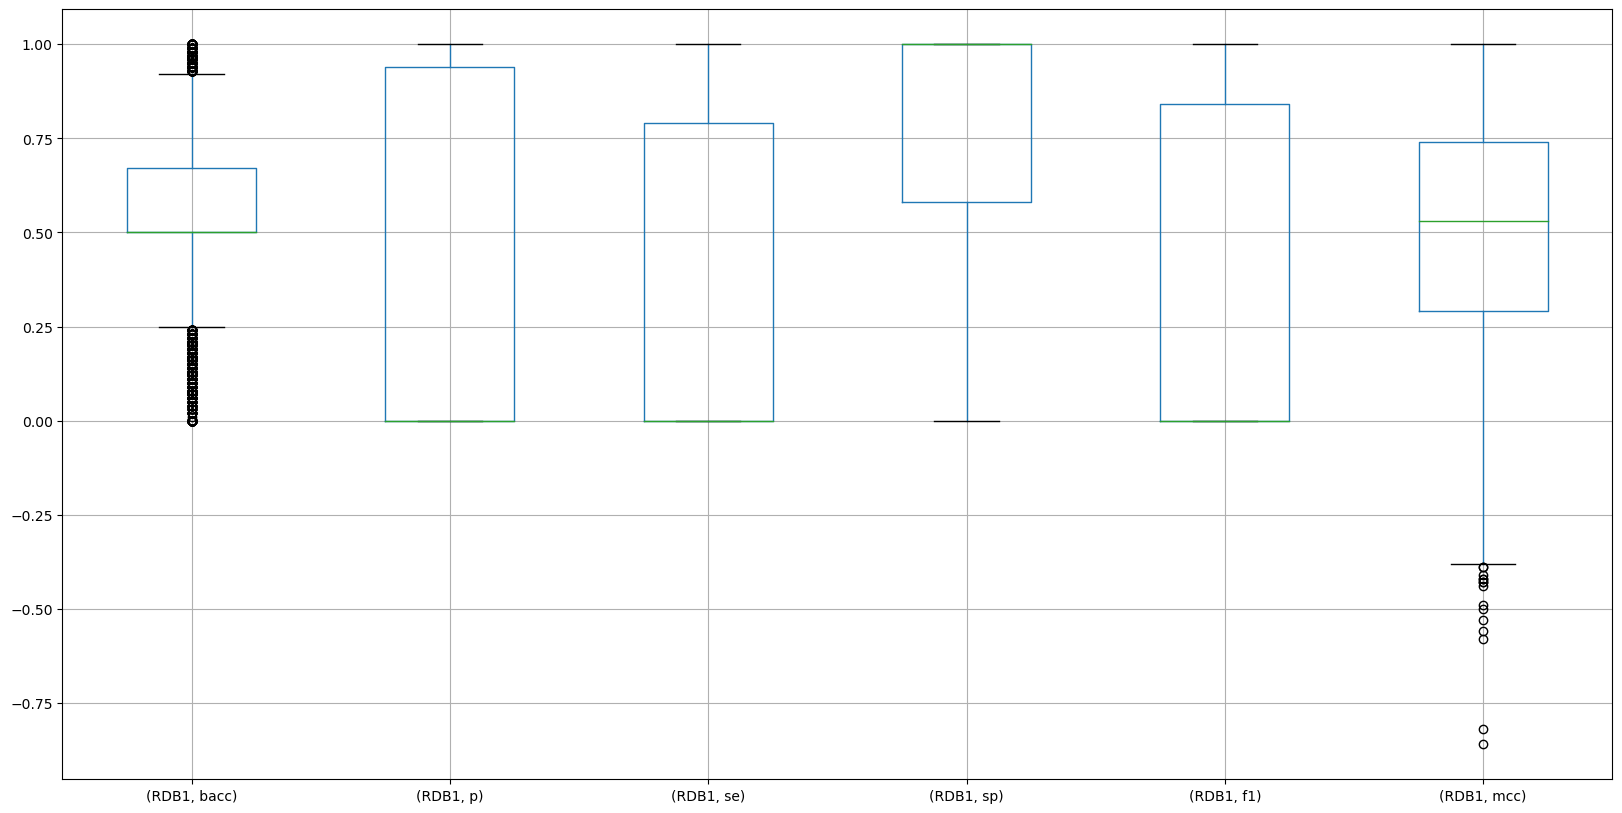

In [13]:
df_.loc[:,('RDB1', ['bacc', 'p', 'se', 'sp', 'f1', 'mcc'])].boxplot(figsize=(20,10))




In [14]:
# df_.loc[:,(slice(None), ['bacc', 'p', 'se', 'sp', 'f1', 'mcc'])].boxplot(figsize=(20,10))

In [15]:
# table region overlap level (positives + negatives)
metrics1 = df_.loc[:,('RDB1', ['bacc', 'p', 'se', 'sp', 'f1', 'mcc'])].mean().round(2)
matrix1 = df_.loc[:,('RDB1', ['TP', 'TN', 'FP', 'FN'])].sum()
metrics2 = df_.loc[:,('RDB2', ['bacc', 'p', 'se', 'sp', 'f1', 'mcc'])].mean().round(2)
matrix2 = df_.loc[:,('RDB2', ['TP', 'TN', 'FP', 'FN'])].sum()
matrix1[0]

451973

In [16]:
data = []
data.append(['RDBLITE1', matrix1[0], matrix1[1], matrix1[2], matrix1[3], len(df), metrics1[0], metrics1[1], metrics1[2], metrics1[3], metrics1[4], metrics1[5]])
data.append(['RDBLITE2',  matrix2[0], matrix2[1], matrix2[2], matrix2[3], len(df), metrics2[0], metrics2[1], metrics2[2], metrics2[3], metrics2[4], metrics2[5]])
table = pd.DataFrame(data, columns=['TOOL', 'TP', 'FP', 'TN', 'FN', 'TOTAL', 'BALANCED ACCURACY', 'PRECISION', 'RECALL', 'F-SCORE', 'MCC', 'TNR1'])
# table.to_csv('tables/table_residue_overlap.csv', index=False)
# table.to_csv('tables/table_residue_overlap_positives.csv', index=False)
table

,TOOL,TP,FP,TN,FN,TOTAL,BALANCED ACCURACY,PRECISION,RECALL,F-SCORE,MCC,TNR1
0,RDBLITE1,451973,756711,220411,557809,1986904,0.53,0.33,0.29,0.77,0.30,0.50
1,RDBLITE2,768967,461908,515214,240815,1986904,0.55,0.56,0.50,0.61,0.51,0.33


In [17]:
# PLOTS: GROUP BY TOPOLOGY, CALC METRICS AND PLOT

# remove the ones with 2 topologies definition for simplification
df_topologies = df[~df["topologies"].astype(str).str.contains(';')]
df_topologies = df_topologies[df_topologies["topologies"].notna()]
df_topologies['topologies'] = df_topologies['topologies'].astype(str)
df_topologies


,pdb_id,pdb_chain,seqres_index,pdb_residue_id,REGION,CURATED,RDB1,RDB2,CATEGORY,UNIT_CURATED,...,topologies,topologies_names,TP_1,TN_1,FP_1,FN_1,TP_2,TN_2,FP_2,FN_2
2,3u3w,B,3,3.0,0,0,1,0,1,0,...,3.3,Alpha-solenoid,0,0,1,0,0,1,0,0
3,3u3w,B,4,4.0,0,0,1,0,1,0,...,3.3,Alpha-solenoid,0,0,1,0,0,1,0,0
4,3u3w,B,5,5.0,0,0,1,0,1,0,...,3.3,Alpha-solenoid,0,0,1,0,0,1,0,0
5,3u3w,B,6,6.0,0,0,1,0,1,0,...,3.3,Alpha-solenoid,0,0,1,0,0,1,0,0
6,3u3w,B,7,7.0,0,0,1,0,1,0,...,3.3,Alpha-solenoid,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1409652,2c0m,C,315,598.0,0,0,0,0,1,0,...,3.3,Alpha-solenoid,0,1,0,0,0,1,0,0
1409653,2c0m,C,316,599.0,0,0,0,0,1,0,...,3.3,Alpha-solenoid,0,1,0,0,0,1,0,0
1409654,2c0m,C,317,600.0,0,0,0,0,1,0,...,3.3,Alpha-solenoid,0,1,0,0,0,1,0,0
1409655,2c0m,C,318,601.0,0,0,0,0,1,0,...,3.3,Alpha-solenoid,0,1,0,0,0,1,0,0


In [18]:
df_top = df_topologies.groupby(['topologies']).agg({'TP_1': 'sum', 'TN_1': 'sum', 'FP_1': 'sum', 'FN_1': 'sum', 'TP_2': 'sum', 'TN_2': 'sum', 'FP_2': 'sum', 'FN_2': 'sum'})


df_top.columns=pd.MultiIndex.from_arrays([['RDB1', 'RDB1', 'RDB1', 'RDB1', 'RDB2', 'RDB2', 'RDB2', 'RDB2'], ['TP', 'TN', 'FP', 'FN', 'TP', 'TN', 'FP', 'FN']])
df_top

RDB1                           RDB2                     
                TP      TN     FP      FN      TP     TN     FP     FN
topologies                                                            
3.1          21800   23678   1469   24400   37140  12389  12758   9060
3.2          25852    8691    466   24801   36120   6589   2568  14533
3.3         143962  105461  16938  133984  241743  53277  69122  36203
3.4           3866    8736    411    6990    8528   4776   4371   2328
3.6              0     222      0   21944   17145    186     36   4799
4.1          73809   35322   6204   76248  105108  22665  18861  44949
4.10          1699      90     17    1097    1122     94     13   1674
4.2          28166   16777   2247   47295   51967  10038   8986  23494
4.3            268     754    110     626     351    430    434    543
4.4         102964   39899   3794  147209  178547  31543  12150  71626
4.5          13328    1483     41   18208   25860   1289    235   5676
4.6           6331     823    271    2016    6435    698    396   1912
4.7            224       0      1       0     108      1      0    116
4.9           5780    1915    370    1279    5041   1324    961   2018
5.1            753      10     11     492     825      9     12    420
5.2           3558     646     20    3651    5439    377    289   1770
5.3           1443     138      8    2062    2317    132     14   1188
5.4           4127     861    109    7541    8015    906     64   3653
5.5           1783     172      7    4656    3757    177      2   2682

In [19]:
# apply calc_metrics function to each row for both RDB1 and RDB2
data = []
for index, row in df_top.iterrows():
    data.append([index, *row[:4], *calc_metrics(*row['RDB1']), *row[4:], *calc_metrics(*row['RDB2'])])
df_top = pd.DataFrame(data)
df_top

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,3.1,21800,23678,1469,24400,0.71,0.94,0.47,0.94,0.63,...,37140,12389,12758,9060,0.65,0.74,0.80,0.49,0.77,0.31
1,3.2,25852,8691,466,24801,0.73,0.98,0.51,0.95,0.67,...,36120,6589,2568,14533,0.72,0.93,0.71,0.72,0.81,0.33
2,3.3,143962,105461,16938,133984,0.69,0.89,0.52,0.86,0.66,...,241743,53277,69122,36203,0.65,0.78,0.87,0.44,0.82,0.34
3,3.4,3866,8736,411,6990,0.66,0.90,0.36,0.96,0.51,...,8528,4776,4371,2328,0.65,0.66,0.79,0.52,0.72,0.32
4,3.6,0,222,0,21944,0.50,0.00,0.00,1.00,0.00,...,17145,186,36,4799,0.81,1.00,0.78,0.84,0.88,0.15
5,4.1,73809,35322,6204,76248,0.67,0.92,0.49,0.85,0.64,...,105108,22665,18861,44949,0.62,0.85,0.70,0.55,0.77,0.21
6,4.10,1699,90,17,1097,0.72,0.99,0.61,0.84,0.75,...,1122,94,13,1674,0.64,0.99,0.40,0.88,0.57,0.11
7,4.2,28166,16777,2247,47295,0.63,0.93,0.37,0.88,0.53,...,51967,10038,8986,23494,0.61,0.85,0.69,0.53,0.76,0.18
8,4.3,268,754,110,626,0.59,0.71,0.30,0.87,0.42,...,351,430,434,543,0.45,0.45,0.39,0.50,0.42,-0.11
9,4.4,102964,39899,3794,147209,0.66,0.96,0.41,0.91,0.58,...,178547,31543,12150,71626,0.72,0.94,0.71,0.72,0.81,0.32


In [20]:
# # # plot
df_top.rename(columns={0: 'topologies'}, inplace=True)
df_top[['c', 't']] = df_top['topologies'].str.split('.', expand=True)
df_top["t"] = pd.to_numeric(df_top["t"])
df_top = df_top.sort_values(['c', 't'])
df_top

,topologies,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,c,t
0,3.1,21800,23678,1469,24400,0.71,0.94,0.47,0.94,0.63,...,12758,9060,0.65,0.74,0.80,0.49,0.77,0.31,3,1
1,3.2,25852,8691,466,24801,0.73,0.98,0.51,0.95,0.67,...,2568,14533,0.72,0.93,0.71,0.72,0.81,0.33,3,2
2,3.3,143962,105461,16938,133984,0.69,0.89,0.52,0.86,0.66,...,69122,36203,0.65,0.78,0.87,0.44,0.82,0.34,3,3
3,3.4,3866,8736,411,6990,0.66,0.90,0.36,0.96,0.51,...,4371,2328,0.65,0.66,0.79,0.52,0.72,0.32,3,4
4,3.6,0,222,0,21944,0.50,0.00,0.00,1.00,0.00,...,36,4799,0.81,1.00,0.78,0.84,0.88,0.15,3,6
5,4.1,73809,35322,6204,76248,0.67,0.92,0.49,0.85,0.64,...,18861,44949,0.62,0.85,0.70,0.55,0.77,0.21,4,1
7,4.2,28166,16777,2247,47295,0.63,0.93,0.37,0.88,0.53,...,8986,23494,0.61,0.85,0.69,0.53,0.76,0.18,4,2
8,4.3,268,754,110,626,0.59,0.71,0.30,0.87,0.42,...,434,543,0.45,0.45,0.39,0.50,0.42,-0.11,4,3
9,4.4,102964,39899,3794,147209,0.66,0.96,0.41,0.91,0.58,...,12150,71626,0.72,0.94,0.71,0.72,0.81,0.32,4,4
10,4.5,13328,1483,41,18208,0.70,1.00,0.42,0.97,0.59,...,235,5676,0.83,0.99,0.82,0.85,0.90,0.34,4,5


In [21]:
df_top.columns=pd.MultiIndex.from_arrays([['id', 'RDB1', 'RDB1', 'RDB1', 'RDB1', 'RDB1', 'RDB1', 'RDB1', 'RDB1', 'RDB1', 'RDB1', 'RDB2', 'RDB2', 'RDB2', 'RDB2', 'RDB2', 'RDB2', 'RDB2', 'RDB2', 'RDB2', 'RDB2', 'id', 'id'], ['topologies', 'TP', 'TN', 'FP', 'FN', 'bacc', 'p', 'se', 'sp', 'f1', 'mcc', 'TP', 'TN', 'FP', 'FN', 'bacc', 'p', 'se', 'sp', 'f1', 'mcc', 'c', 't']])
df_top

id    RDB1                                                       \
   topologies      TP      TN     FP      FN  bacc     p    se    sp    f1   
0         3.1   21800   23678   1469   24400  0.71  0.94  0.47  0.94  0.63   
1         3.2   25852    8691    466   24801  0.73  0.98  0.51  0.95  0.67   
2         3.3  143962  105461  16938  133984  0.69  0.89  0.52  0.86  0.66   
3         3.4    3866    8736    411    6990  0.66  0.90  0.36  0.96  0.51   
4         3.6       0     222      0   21944  0.50  0.00  0.00  1.00  0.00   
5         4.1   73809   35322   6204   76248  0.67  0.92  0.49  0.85  0.64   
7         4.2   28166   16777   2247   47295  0.63  0.93  0.37  0.88  0.53   
8         4.3     268     754    110     626  0.59  0.71  0.30  0.87  0.42   
9         4.4  102964   39899   3794  147209  0.66  0.96  0.41  0.91  0.58   
10        4.5   13328    1483     41   18208  0.70  1.00  0.42  0.97  0.59   
11        4.6    6331     823    271    2016  0.76  0.96  0.76  0.75  0.85   
12        4.7     224       0      1       0  0.50  1.00  1.00  0.00  1.00   
13        4.9    5780    1915    370    1279  0.83  0.94  0.82  0.84  0.88   
6        4.10    1699      90     17    1097  0.72  0.99  0.61  0.84  0.75   
14        5.1     753      10     11     492  0.54  0.99  0.60  0.48  0.75   
15        5.2    3558     646     20    3651  0.73  0.99  0.49  0.97  0.66   
16        5.3    1443     138      8    2062  0.68  0.99  0.41  0.95  0.58   
17        5.4    4127     861    109    7541  0.62  0.97  0.35  0.89  0.52   
18        5.5    1783     172      7    4656  0.62  1.00  0.28  0.96  0.43   

    ...   RDB2                                            id      
    ...     FP     FN  bacc     p    se    sp    f1   mcc  c   t  
0   ...  12758   9060  0.65  0.74  0.80  0.49  0.77  0.31  3   1  
1   ...   2568  14533  0.72  0.93  0.71  0.72  0.81  0.33  3   2  
2   ...  69122  36203  0.65  0.78  0.87  0.44  0.82  0.34  3   3  
3   ...   4371   2328  0.65  0.66  0.79  0.52  0.72  0.32  3   4  
4   ...     36   4799  0.81  1.00  0.78  0.84  0.88  0.15  3   6  
5   ...  18861  44949  0.62  0.85  0.70  0.55  0.77  0.21  4   1  
7   ...   8986  23494  0.61  0.85  0.69  0.53  0.76  0.18  4   2  
8   ...    434    543  0.45  0.45  0.39  0.50  0.42 -0.11  4   3  
9   ...  12150  71626  0.72  0.94  0.71  0.72  0.81  0.32  4   4  
10  ...    235   5676  0.83  0.99  0.82  0.85  0.90  0.34  4   5  
11  ...    396   1912  0.70  0.94  0.77  0.64  0.85  0.29  4   6  
12  ...      0    116  0.74  1.00  0.48  1.00  0.65  0.06  4   7  
13  ...    961   2018  0.65  0.84  0.71  0.58  0.77  0.26  4   9  
6   ...     13   1674  0.64  0.99  0.40  0.88  0.57  0.11  4  10  
14  ...     12    420  0.55  0.99  0.66  0.43  0.79  0.02  5   1  
15  ...    289   1770  0.66  0.95  0.75  0.57  0.84  0.20  5   2  
16  ...     14   1188  0.78  0.99  0.66  0.90  0.79  0.23  5   3  
17  ...     64   3653  0.81  0.99  0.69  0.93  0.81  0.34  5   4  
18  ...      2   2682  0.79  1.00  0.58  0.99  0.74  0.19  5   5  

[19 rows x 23 columns]

In [22]:
# table topologies
df_1 = df_top
df_1.columns = pd.MultiIndex.from_arrays([['topologies', 'TP', 'TN', 'FP', 'FN', 'bacc', 'p', 'se', 'sp', 'f1', 'mcc', 'TP', 'TN', 'FP', 'FN', 'bacc', 'p', 'se', 'sp', 'f1', 'mcc', 'c', 't']])
df_1 = df_1.iloc[:,0:11]
df_1['tool'] = 'RDBLITE1'

df_2 = df_top
df_2.columns = pd.MultiIndex.from_arrays([['topologies', 'TP', 'TN', 'FP', 'FN', 'bacc', 'p', 'se', 'sp', 'f1', 'mcc', 'TP', 'TN', 'FP', 'FN', 'bacc', 'p', 'se', 'sp', 'f1', 'mcc', 'c', 't']])
df_2 = df_2.iloc[:,11:21]
df_2['tool'] = 'RDBLITE2'
df_2['topologies'] = df_1['topologies']

cols = list(df_2.columns)
cols = [cols[-1]] + cols[:-1]
df_2 = df_2[cols]
df_merge_top = pd.concat([df_1, df_2]).sort_index()
df_merge_top.to_csv('tables/table_topologies.csv', index=False)

In [23]:
# plot
x = ['3.1 Beta-solenoid', '3.2 Alpha/beta solenoid',
     '3.3 Alpha-solenoid', '3.4 Beta hairpins', '3.6 Box', '4.1 TIM-barrel', '4.2 Beta-barrel / beta hairpins',
     '4.3 Beta-trefoil', '4.4 Propeller', '4.5 Alpha/beta prism',
     '4.6 Alpha-barrel', '4.7 Alpha/beta barrel','4.9 Alpha/beta trefoil',  '4.10 Aligned prism',
     '5.1 Alpha-beads', '5.2 Beta-beads', '5.3 Alpha/beta-beads', '5.4 Beta sandwich beads', '5.5 Alpha/beta sandwich beads']

# RDBL 1

fig = make_subplots(rows=2, cols=1)
fig.add_trace(go.Bar(
    y= np.array(df_top[('RDB2','bacc')].values.tolist()) -  np.array(df_top[('RDB1','bacc')].values.tolist()),
    x=x,
    name='accuracy',
    marker_color='#EDAE49'
), row=1, col=1)
fig.add_trace(go.Bar(
    y=np.array(df_top[('RDB2','p')].values.tolist()) - np.array(df_top[('RDB1','p')].values.tolist()),
    x=x,
    name='precision',
    marker_color='#D1495B'
), row=1, col=1)
fig.add_trace(go.Bar(
    y=np.array(df_top[('RDB2','se')].values.tolist()) - np.array(df_top[('RDB1','se')].values.tolist()),
    x=x,
    name='recall',
    marker_color='#00798C'
), row=1, col=1)
fig.add_trace(go.Bar(
    y=np.array(df_top[('RDB2','f1')].values.tolist()) - np.array(df_top[('RDB1','f1')].values.tolist()),
    x=x,
    name='f-score',
    marker_color='#003D5B'
), row=1, col=1)

KeyError: 'Key length (2) exceeds index depth (1)'

In [ ]:
 # PDBS distribution
df_pdbs = pd.DataFrame.from_dict(Counter(df_topologies['topologies']), orient='index', columns=['#PDBs'])

fig.add_trace(go.Bar(
    y=df_pdbs['#PDBs'].values.tolist(),
    x=x,
    name='PDBs',
    marker_color='#003D5F'
), row=2, col=1)
fig.update_layout(title='RepeatsDB-lite2 - RepeatsDB-lite1', width=1000, height=1000)
# fig.write_image("plots/a_p_r_m_dataset_rdb3.png")

In [ ]:
# RDBL 1

fig1 = make_subplots(rows=1, cols=1)
fig1.add_trace(go.Bar(
    y= df_top[('RDB1','bacc')].values.tolist(),
    x=x,
    name='accuracy',
    marker_color='#EDAE49'
), row=1, col=1)
fig1.add_trace(go.Bar(
    y=df_top[('RDB1','p')].values.tolist(),
    x=x,
    name='precision',
    marker_color='#D1495B'
), row=1, col=1)
fig1.add_trace(go.Bar(
    y=df_top[('RDB1','se')].values.tolist(),
    x=x,
    name='recall',
    marker_color='#00798C'
), row=1, col=1)
fig1.add_trace(go.Bar(
    y=df_top[('RDB2','f1')].values.tolist(),
    x=x,
    name='f-score',
    marker_color='#003D5B'
), row=1, col=1)
# fig1.write_image("plots/a_p_r_m_dataset_rdb1.png")

In [ ]:
# RDBL 2

fig2 = make_subplots(rows=1, cols=1)
fig2.add_trace(go.Bar(
    y= df_top[('RDB2','bacc')].values.tolist(),
    x=x,
    name='accuracy',
    marker_color='#EDAE49'
), row=1, col=1)
fig2.add_trace(go.Bar(
    y=df_top[('RDB2','p')].values.tolist(),
    x=x,
    name='precision',
    marker_color='#D1495B'
), row=1, col=1)
fig2.add_trace(go.Bar(
    y=df_top[('RDB2','se')].values.tolist(),
    x=x,
    name='recall',
    marker_color='#00798C'
), row=1, col=1)
fig2.add_trace(go.Bar(
    y=df_top[('RDB2','f1')].values.tolist(),
    x=x,
    name='f-score',
    marker_color='#003D5B'
), row=1, col=1)
# fig2.write_image("plots/a_p_r_m_dataset_rdb2.png")

In [ ]:
# boxplots PDB - topologies
# apply calc_metrics function to each row for both RDB1 and RDB2
data = []
for index, row in df_prot.iterrows():
    # print(*row['RDB1'], *calc_metrics(*row['RDB1']))
    data.append([index[0], index[1], index[2], *row[:4], *calc_metrics(*row['RDB1']), *row[4:], *calc_metrics(*row['RDB2'])])
df_classes = pd.DataFrame(data)
df_classes
df_classes.rename(columns={0: 'pdb_id'}, inplace=True)
df_classes.rename(columns={1: 'pdb_chain'}, inplace=True)
df_boxplots = df_classes.merge(df_topologies, how='right', on=['pdb_id', 'pdb_chain'])
df_boxplots

In [ ]:
# accuracy
df_boxplots.rename(columns={7: 'a1'}, inplace=True)
df_boxplots.rename(columns={17: 'a2'}, inplace=True)
df_plot1 = df_boxplots[['a1', 'topologies']].rename(columns={"a1": "accuracy"})
df_plot2 = df_boxplots[['a2', 'topologies']].rename(columns={"a2": "accuracy"})
df_plot1['tool'] = 'RepeatsDB-lite1'
df_plot2['tool'] = 'RepeatsDB-lite2'

df_final = pd.concat([df_plot1, df_plot2])
df_final = df_final.sort_values(by=['topologies'], ascending=True)
df_final[['class','subclass']] = df_final['topologies'].str.split('.',expand=True)

fig = px.box(df_final, x="topologies", y="accuracy", color='tool')
fig.update_layout(width=1000)
fig.write_image("plots/accuracy_pdbs.png")
fig = px.box(df_final, x="class", y="accuracy", color='tool')
fig.show()
fig.update_layout(width=1000)
fig.write_image("plots/accuracy_pdbs_classes.png")

In [ ]:
# precision
df_boxplots.rename(columns={8: 'p1'}, inplace=True)
df_boxplots.rename(columns={18: 'p2'}, inplace=True)
df_plot1 = df_boxplots[['p1', 'topologies']].rename(columns={'p1': "precision"})
df_plot2 = df_boxplots[['p2', 'topologies']].rename(columns={'p2': "precision"})
df_plot1['tool'] = 'RepeatsDB-lite1'
df_plot2['tool'] = 'RepeatsDB-lite2'
df_final = pd.concat([df_plot1, df_plot2])
df_final = df_final.sort_values(by=['topologies'], ascending=True)
df_final[['class','subclass']] = df_final['topologies'].str.split('.',expand=True)


fig = px.box(df_final, x="topologies", y="precision", color='tool')
fig.update_layout(width=1000)
fig.write_image("plots/precision_pdbs.png")
fig = px.box(df_final, x="class", y="precision", color='tool')
fig.update_layout(width=1000)
fig.write_image("plots/precision_pdbs_classes.png")


In [ ]:
# recall
df_boxplots.rename(columns={9: 'r1'}, inplace=True)
df_boxplots.rename(columns={19: 'r2'}, inplace=True)
df_plot1 = df_boxplots[['r1', 'topologies']].rename(columns={"r1": "recall"})
df_plot2 = df_boxplots[['r2', 'topologies']].rename(columns={"r2": "recall"})
df_plot1['tool'] = 'RepeatsDB-lite1'
df_plot2['tool'] = 'RepeatsDB-lite2'
df_final = pd.concat([df_plot1, df_plot2])
df_final = df_final.sort_values(by=['topologies'], ascending=True)
df_final[['class','subclass']] = df_final['topologies'].str.split('.',expand=True)


fig = px.box(df_final, x="topologies", y="recall", color='tool')
fig.update_layout(width=1000)
fig.write_image("plots/recall_pdbs.png")
fig = px.box(df_final, x="class", y="recall", color='tool')
fig.update_layout(width=1000)
fig.write_image("plots/recall_pdbs_classes.png")


In [ ]:
# F score
df_boxplots.rename(columns={10: 'f1'}, inplace=True)
df_boxplots.rename(columns={20: 'f2'}, inplace=True)
df_f1 = df_boxplots[['f1', 'topologies']].rename(columns={"f1": "f-score"})
df_f2 = df_boxplots[['f2', 'topologies']].rename(columns={"f2": "f-score"})
df_f1['tool'] = 'RepeatsDB-lite1'
df_f2['tool'] = 'RepeatsDB-lite2'
df_final = pd.concat([df_f1, df_f2])
df_final = df_final.sort_values(by=['topologies'], ascending=True)
df_final[['class','subclass']] = df_final['topologies'].str.split('.',expand=True)

fig = px.box(df_final, x="topologies", y="f-score", color='tool')
fig.update_layout(width=1000)
fig.write_image("plots/f-score_pdbs.png")
fig = px.box(df_final, x="class", y="f-score", color='tool')
fig.update_layout(width=1000)
fig.write_image("plots/f-score_pdbs_classes.png")

# f1 by method
fig = px.box(df_final, x="tool", y="f-score")
fig.write_image("plots/f-score_by_method.png")